In [8]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F

In [10]:
def numberToTensor(n, n_max=1000):
    tensor = torch.zeros(n_max).long().view(1, -1)
    if n < n_max:
        tensor[0][n] = 1
    else:
        raise RunTimeError("n > n_max")
    return tensor

def variableToNumber(variable):
    return np.argmax(variable.data.numpy())

In [11]:
def generateExample():
    list_example = list()
    #while True:
    #    l = np.random.multinomial(1, (0.45, 0.45, 0.1))
    #    res = np.argmax(l)
    #    if res == 0:
    #        list_example.append(0)
    #    elif res == 1:
    #        list_example.append(1)
    #    else:
    #        if len(list_example) > 0:
    #            break
    n = np.random.randint(1, 20)
    for i in range(n):
        list_example.append(np.random.binomial(1, 0.65))
    return Variable(torch.FloatTensor(list_example)), Variable(torch.LongTensor([sum(list_example)]))

def generateExample2():
    n = np.random.randint(1, 20)
    list_example = [0 for i in range(n)]
    k = np.random.randint(n + 1)
    if k > 0:
        one_indices_list = np.random.choice([i for i in range(n)], k, replace=False)
        for i in one_indices_list:
            list_example[i] = 1
    return Variable(torch.FloatTensor(list_example)), Variable(torch.LongTensor([sum(list_example)]))

print(generateExample2())

(Variable containing:
 1
 1
[torch.FloatTensor of size 2]
, Variable containing:
 2
[torch.LongTensor of size 1]
)


In [12]:
def loss_weights(n_outputs=10):
    list_counts = [0 for i in range(n_outputs)]
    n_iters = 50000
    for i in range(n_iters):
        target = generateExample2()[1].data[0]
        list_counts[target] += 1
    list_weight = list()
    for a in list_counts:
        if a:
            list_weight.append(1e15 / float(a)**4)
        else:
            list_weight.append(0)
    return list_weight
    
print(loss_weights(n_outputs=20))

[0.4822805020442291, 0.43307766228730177, 1.1112941707648578, 1.8822321018429329, 4.046012623091953, 8.006717278940782, 11.540673897561094, 18.678023704280374, 42.84392472975761, 61.8788868038587, 96.97236303784658, 181.06369572148014, 317.67504540171694, 695.5742934836381, 1264.6001501742212, 3521.3448607609184, 10024.315748543226, 39853.61414262976, 190981.31528362405, 4665073.8020973345]


In [13]:
torch.FloatTensor([0])


 0
[torch.FloatTensor of size 1]

In [14]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.lin = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax()
    
    def forward(self, input, hidden):
        #combined = torch.cat((input, hidden), 1)
        output, hidden = self.lstm(input.view(len(input), 1, -1), hidden)

        output = self.lin(output.view(1, -1))

        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return (Variable(torch.zeros(1, 1, self.hidden_size)),
                Variable(torch.zeros(1, 1, self.hidden_size)))

    
n_hidden = 32
rnn = RNN(1, n_hidden, 20)

In [15]:
class RNN2(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN2, self).__init__()
        
        self.hidden = None
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        #self.softmax = nn.
    
    def forward(self, input, hidden):
        combined = torch.cat([input.view(1, 1), hidden], 1)

        hidden = self.i2h(combined)
        if self.training == "eval":
            print("yep")
            self.hidden = hidden
        output = self.i2o(combined)
        #output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return Variable(torch.zeros(1, self.hidden_size))
    
n_hidden = 32
rnn2 = RNN2(1, n_hidden, 1)


In [16]:
criterion = nn.NLLLoss(weight=torch.FloatTensor(loss_weights(20)))

In [33]:
learning_rate = 0.0005
optimizer = torch.optim.SGD(rnn.parameters(), lr = learning_rate)

def train(category_tensor, line_tensor): 
    hidden = rnn.initHidden()

    optimizer.zero_grad()
    for i in range(line_tensor.size()[0]):
        
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    #Add parameters' gradients to their values, multiplied by learning rate
    optimizer.step()

    return output, loss.data[0]

In [34]:
sequence, target = generateExample()

output, loss_data = train(target, sequence)

In [35]:
loss_data

0.03545009344816208

In [36]:
import time
import math

In [37]:
n_iters = 100000
print_every = 2000
plot_every = 1000

In [ ]:
# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()
n_categories = 50
list_guess = [0 for i in range(n_categories)]
list_category = [0 for i in range(n_categories)]
list_precision = [0 for i in range(n_categories)]
list_recall = [0 for i in range(n_categories)]
for iter in range(1, n_iters + 1):
    line_tensor, category_tensor = generateExample2()
    max_loss = 0
    worst_example = None
    output, loss = train(category_tensor, line_tensor)
    category = category_tensor.data[0]
    line = line_tensor.data.numpy()
    current_loss += loss
    guess = variableToNumber(output)
    if loss > max_loss:
        max_loss = loss
        worst_example = (line_tensor.data.numpy(), guess, category)
    list_guess[guess] += 1
    list_category[category] += 1
    if guess == category:
        list_precision[guess] += 1
        list_recall[category] += 1
    # Print iter number, loss name and guess
    if iter % print_every == 0:
        correct =  '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, float(iter) / n_iters * 100, timeSince(start), loss, line, guess, correct))
        for i in range(len(list_recall)):
            if list_category[i]:
                list_recall[i] = list_recall[i] / float(list_category[i])
            else:
                list_recall[i] = np.nan
        for i in range(len(list_precision)):
            if list_guess[i]:
                list_precision[i] = list_precision[i] / float(list_guess[i])
            else:
                list_precision[i] = np.nan
        print(list_guess)
        print(list_precision)
        print(list_category)
        print(list_recall)
        print(worst_example)
        list_guess = [0 for i in range(n_categories)]
        list_category = [0 for i in range(n_categories)]
        list_precision = [0 for i in range(n_categories)]
        list_recall = [0 for i in range(n_categories)]
    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0


# Plotting the results

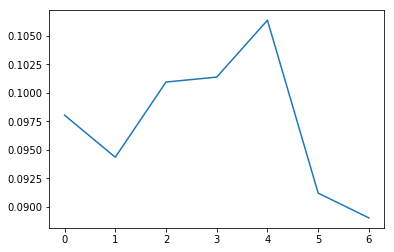

In [40]:
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker


plt.plot(all_losses)
plt.show()

In [31]:
def evaluate(line_tensor):
    hidden = rnn.initHidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        
    return output

In [41]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line.data.numpy())
    output = evaluate(input_line)
    
    # Get top N categories
    topv, topi = output.data.topk(n_predictions, 1, True)
    predictions = []
    
    for i in range(n_predictions):
        value = math.exp(topv[0][i])
        category_index = topi[0][i]
        print('(%.2f) %s' % (value, category_index))
        predictions.append([value, category_index])
    
predict(Variable(torch.FloatTensor([0, 0,0, 1,1,  0, 1, 1, 1, 0, 1, 1, 0, 1, 1 ,  1, 1, 0, 0, 1, 0, 1,0, 0])))
predict(Variable(torch.FloatTensor([0 for i in range(100)])))
predict(Variable(torch.FloatTensor([1 for i in range(13)])))


> [ 0.  0.  0.  1.  1.  0.  1.  1.  1.  0.  1.  1.  0.  1.  1.  1.  1.  0.
  0.  1.  0.  1.  0.  0.]
(0.52) 14
(0.25) 13
(0.10) 12

> [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
(1.00) 0
(0.00) 1
(0.00) 2

> [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
(0.79) 13
(0.10) 14
(0.10) 12


In [ ]:
list(rnn.children())[0].weight.data.numpy()

In [1]:
def train(input_line_tensor, target_line_tensor):
    hidden = rnn.initHidden()
    optimizer.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size()[0]):
        output, hidden = rnn(input_line_tensor[i], hidden)

        loss += criterion(output, target_line_tensor[i])

            

    loss.backward()
    optimizer.step()


    return output, loss.data[0] / input_line_tensor.size()[0]

In [122]:
## WARNING : may not work for multiple layers
def visualize(rnn, input_tensor, neurons):
    hidden = rnn.initHidden()
    activation_list = [[] for i in range(len(neurons))]
    for i in range(input_tensor.size()[0]):
        former_hidden = hidden
        output, hidden = rnn(input_tensor[i], hidden)
        for i, neuron in enumerate(neurons): 

            W_igate = rnn.lstm.weight_ih_l0
            W_hgate = rnn.lstm.weight_hh_l0
            b_igate = rnn.lstm.bias_ih_l0
            b_hgate = rnn.lstm.bias_hh_l0 

            input_part = torch.mm(W_igate, input_tensor[i].view(-1, 1)) + b_igate
            hidden_part = Variable(torch.from_numpy(np.dot(W_hgate.data.numpy(), former_hidden[0].data.view(-1, 1).numpy())))
            activation = F.sigmoid(input_part + hidden_part)[neuron["index"]]
            activation_list[i].append(activation.data.numpy()[0])
    return input_tensor, activation_list
            
    

neurons = [{"gate":0, "layer":1, "index":6}, {"gate":1, "layer":1, "index":19}, {"gate":0, "layer":1, "index":87}, {"gate":0, "layer":1, "index":9}, {"gate":0, "layer":1, "index":7}]
visualize(rnn, Variable(torch.FloatTensor([0, 1,0, 1,1])), neurons)

(Variable containing:
  0
  1
  0
  1
  1
 [torch.FloatTensor of size 5],
 [[0.51439959, 0.34910899, 0.46802357, 0.43828213, 0.69733369],
  [0.72301918, 0.6165787, 0.69856465, 0.71001267, 0.82991183],
  [0.65378559, 0.89559823, 0.91417611, 0.95468724, 0.95147717],
  [0.51479614, 0.19754966, 0.25212124, 0.18745415, 0.2833752],
  [0.66619927, 0.76935124, 0.86564255, 0.88173443, 0.91953599]])

In [170]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Ceci_n'est_pas_un_texte


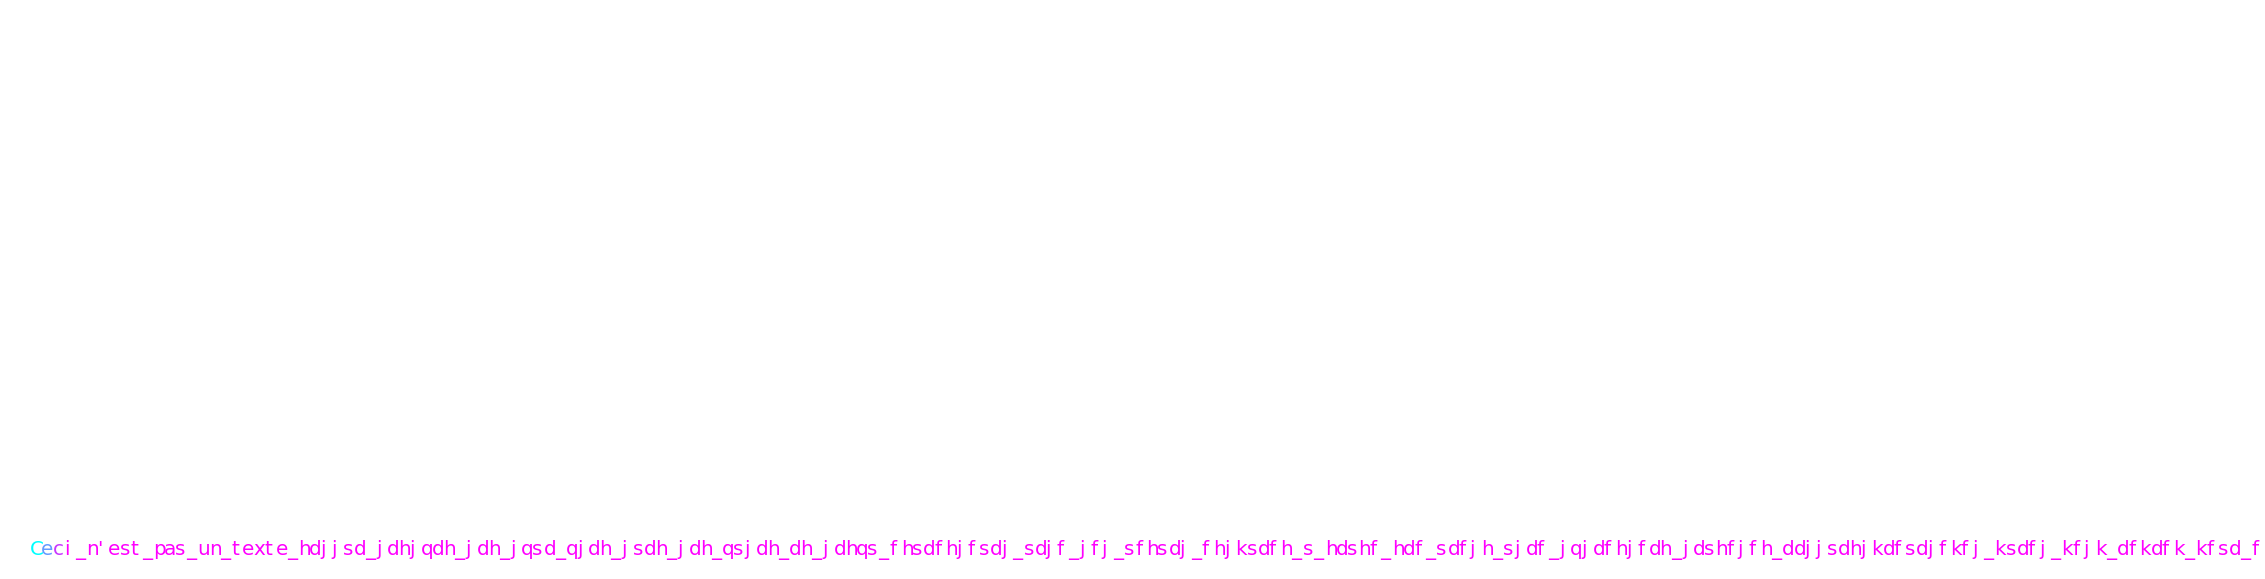

In [233]:
import matplotlib.pyplot as plt
from matplotlib import cm

def show_space(text):
    new_text = ""
    for letter in text:
        if letter == " ":
            new_text += "_"
        else:
            new_text += letter
    return new_text

def text_color_map(text, value_list):
    x_scale = 12
    y_scale = 10
    plt.figure(figsize=(x_scale, y_scale))
    plt.axis("off")
    letter_size = 20
    reset_corrector = 0
    for i in range(200):
        letter = text[i]
        value = value_list[i]
        x_pos = (i - reset_corrector)  * 1E-2 *  letter_size / x_scale
        y_pos = 0
        if x_pos + letter_size / x_scale < x_scale:
            plt.text(x_pos , y_pos, letter, size = letter_size, color = cm.cool(value))
        else:
            reset_corrector = i
            x_pos = 0
            y_pos = 0
            plt.text(x_pos , y_pos, letter, size = letter_size, color = cm.cool(value))
    
print(show_space("Ceci n'est pas un texte"))
text_color_map(show_space("Ceci n'est pas un texte hdjjsd jdhjqdh jdh jqsd qjdh jsdh jdh qsjdh dh jdhqs fhsdfhjfsdj sdjf jfj sfhsdj fhjksdfh s hdshf hdf sdfjh sjdf jqjdfhjfdh jdshfjfh ddjjsdhjkdfsdjfkfj ksdfj kfjk dfkdfk kfsd fh"), [100 * i for i in range(1000)])

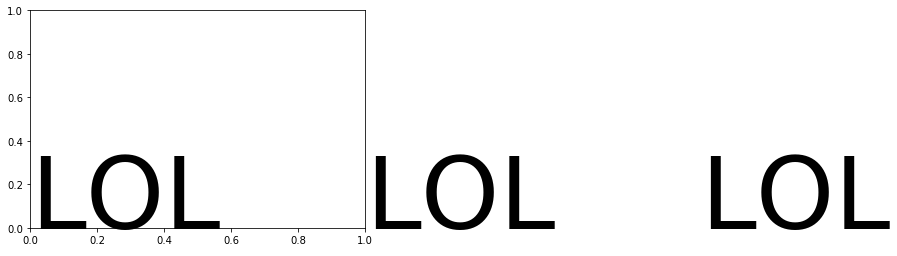

In [190]:
plt.text(0, 0, "LOL", size = 100)
plt.text(1, 0, "LOL", size = 100)
plt.text(2, 0, "LOL", size = 100)

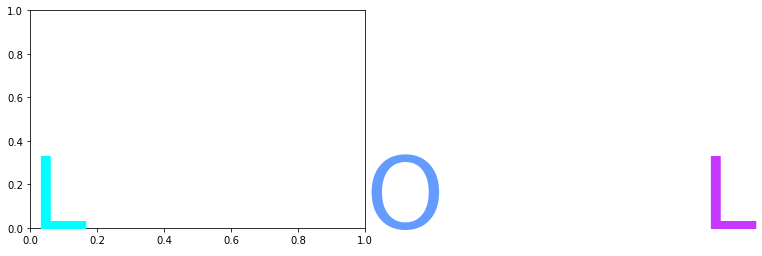

In [198]:
text = "LOL"
for i in range(3):
    letter
    plt.text(i, 0, text[i], size = 100, color = cm.cool(i *100))